# Install

In [1]:
!pip install panns-inference

# Collegamento con il Drive

In [2]:
from google.colab import drive
drive.mount("/content/drive")

!ls '/content/drive/My Drive/SonART/Demo'

Mounted at /content/drive
'asmr EGG CRACKING sound.mp3'
'Bird Flapping Wings Sound Effect.mp3'
'Busy Street [Sound Effect].mp3'
 cat-purring-68797.mp3
 egg-crack5-104555.mp3
 egg-cracking-6844.mp3
'Egg Shell Crack Sound Effect - Egg Cracking sound.mp3'
'Heart Beat [SOUND EFFECT].mp3'
'Hungry Cat Sound Effects - Hungry Cat Meowing Sound shorts.mp3'
'Long Mud Pour Sound Effect.mp3'
'Meow Sound Effect.mp3'
' Royalty-Free Sounds.mp3'
'Seagull - Sound Effect.mp3'
'seagull sound.mp3'
'Sea Waves - Sound Effect.mp3'
'SonART Demo v1.wav'
'SonART Demo v2.wav'
'SonART Demo v3.wav'
'SonART Demo v4.wav'
'SonART Demo v5.wav'
'SonART Demo v6.wav'
'SonART Demo v7.wav'
'SonART Demo v8.wav'
'Sound effect - Campane - Bells.mp3'
 splash-6213.mp3


# Import

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels

# Audio tagging and sound event detection with Panns

In [4]:
def print_audio_tagging_result(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    # Print audio tagging top probabilities
    for k in range(10):
        print('{}: {:.3f}'.format(np.array(labels)[sorted_indexes[k]],
            clipwise_output[sorted_indexes[k]]))

In [5]:
def plot_sound_event_detection_result(framewise_output):
    """Visualization of sound event detection result.

    Args:
      framewise_output: (time_steps, classes_num)
    """
    out_fig_path = 'results/sed_result.png'
    os.makedirs(os.path.dirname(out_fig_path), exist_ok=True)

    classwise_output = np.max(framewise_output, axis=0) # (classes_num,)

    idxes = np.argsort(classwise_output)[::-1]
    idxes = idxes[0:5]

    ix_to_lb = {i : label for i, label in enumerate(labels)}
    lines = []
    for idx in idxes:
        line, = plt.plot(framewise_output[:, idx], label=ix_to_lb[idx])
        lines.append(line)

    plt.legend(handles=lines)
    plt.xlabel('Frames')
    plt.ylabel('Probability')
    plt.ylim(0, 1.)
    plt.savefig(out_fig_path)
    print('Save fig to {}'.format(out_fig_path))

------ Audio tagging ------
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Music: 0.378
Bird: 0.153
Duck: 0.131
Animal: 0.089
Goose: 0.083
Honk: 0.074
Bird vocalization, bird call, bird song: 0.065
Quack: 0.045
Outside, rural or natural: 0.043
Fowl: 0.039
------ Sound event detection ------
Checkpoint path: /root/panns_data/Cnn14_DecisionLevelMax.pth
Using CPU.
Save fig to results/sed_result.png


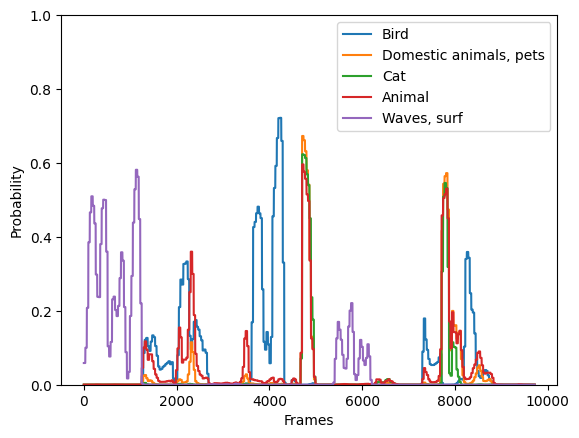

In [36]:
device = 'cpu' # 'cuda' | 'cpu'
audio_path = "/content/drive/My Drive/SonART/Demo/SonART Demo v8.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)
audio = audio[None, :]  # (batch_size, segment_samples)

print('------ Audio tagging ------')
at = AudioTagging(checkpoint_path="/root/panns_data/Cnn14_mAP=0.431.pth", device=device)
(clipwise_output, embedding) = at.inference(audio)
"""clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

print_audio_tagging_result(clipwise_output[0])

print('------ Sound event detection ------')
sed = SoundEventDetection(
    checkpoint_path=None,
    device=device,
    interpolate_mode='nearest', # 'nearest'
)
framewise_output = sed.inference(audio)
"""(batch_size, time_steps, classes_num)"""

plot_sound_event_detection_result(framewise_output[0])

# MODELLO SENZA MODIFICHE

In [6]:
def best_tag(clipwise_output):
    """Visualization of audio tagging result.

    Args:
      clipwise_output: (classes_num,)
    """
    sorted_indexes = np.argsort(clipwise_output)[::-1]

    return sorted_indexes[0]

In [7]:
device = 'cpu' # 'cuda' | 'cpu'
audio_path = "/content/drive/My Drive/SonART/Demo/SonART Demo v8.wav"
(audio, _) = librosa.core.load(audio_path, sr=32000, mono=True)

In [9]:
# **Specifica la durata dei segmenti in secondi**
segment_duration = 3 # Durata del segmento in secondi (esempio: 2 secondi)
hop_duration = 1   # Durata del salto tra segmenti in secondi (esempio: 1 secondo)

# Calcolare la lunghezza di ogni segmento in campioni
segment_length = int(segment_duration * 32000)
hop_length = int(hop_duration * 32000)

# Dividere il waveform in segmenti con il salto specificato
segments = []
for start in range(0, len(audio) - segment_length + 1, hop_length):
    segment = audio[start:start + segment_length]
    segments.append(segment)

# Aggiungere l'ultimo segmento se non coperto dal ciclo (padding se necessario)
if len(audio) % hop_length != 0:
    last_segment = audio[-segment_length:]
    segments.append(last_segment)

# Trasformare i segmenti in un array numpy
segments = np.stack(segments)

# Mostrare dettagli
print(f"Numero di segmenti: {len(segments)}, Forma di ogni segmento: {segments[0].shape}")

Numero di segmenti: 96, Forma di ogni segmento: (96000,)


In [39]:
tag_list = []

for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  at = AudioTagging(checkpoint_path='/root/panns_data/Cnn14_mAP=0.431.pth', device=device)
  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]


  print('{}: {:.3f}'.format(predicted_class,clipwise_output[index]))
  tag_list.append(predicted_class)

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.700
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.720
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.757
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.678
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.715
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.635
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.474
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.704
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Honk: 0.513

In [40]:
for element in tag_list:
    print(element)

Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Honk
Goose
Honk
Honk
Honk
Honk
Honk
Goose
Owl
Owl
Animal
Honk
Honk
Honk
Goose
Goose
Pour
Boat, Water vehicle
Music
Music
Music
Animal
Animal
Animal
Bird
Bird
Bird flight, flapping wings
Bird flight, flapping wings
Bird
Bird
Bird
Bird
Vehicle
Vehicle
Animal
Cat
Cat
Cat
Cat
Pulse
Pulse
Heart sounds, heartbeat
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Music
Music
Purr
Purr
Purr
Purr
Purr
Crack
Coin (dropping)
Coin (dropping)
Fowl
Goose
Honk
Honk
Cat
Cat
Cat
Animal
Cat
Cat
Bird
Bird
Bird
Goose
Animal
Music
Church bell
Church bell
Church bell
Church bell
Music
Church bell
Church bell
Church bell
Church bell


# AGGIUNTA DI UNA SOGLIA

In [41]:
tag_list = []

for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  at = AudioTagging(checkpoint_path='/root/panns_data/Cnn14_mAP=0.431.pth', device=device)
  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]

  if(clipwise_output[index] >= 0.400):
    print('{}: {:.3f}'.format(predicted_class,clipwise_output[index]))
    tag_list.append(predicted_class)

Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.700
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.720
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.757
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.678
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.715
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.635
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.474
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.704
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.748
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Honk: 0.513

In [42]:
for element in tag_list:
    print(element)

Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Honk
Goose
Honk
Honk
Honk
Honk
Honk
Goose
Owl
Honk
Honk
Honk
Goose
Goose
Bird
Bird
Bird
Bird
Vehicle
Vehicle
Animal
Cat
Cat
Cat
Cat
Pulse
Pulse
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Waves, surf
Purr
Purr
Purr
Purr
Fowl
Goose
Honk
Honk
Cat
Cat
Cat
Animal
Cat
Cat
Bird
Goose
Animal
Church bell
Church bell
Church bell
Church bell
Church bell
Church bell
Church bell
Church bell


# VERSIONE DEMO NORMALE




In [37]:
# Variabile per tracciare la parola precedentemente stampata
last_printed_word = None
# Variabile per tracciare la parola precedente all'iterazione attuale
previous_word = None

tag_list = []

for segment in segments:
  segment = segment[None, :]  # (batch_size, segment_samples)

  at = AudioTagging(checkpoint_path='/root/panns_data/Cnn14_mAP=0.431.pth', device=device)
  (clipwise_output, embedding) = at.inference(segment)
  """clipwise_output: (batch_size, classes_num), embedding: (batch_size, embedding_size)"""

  index = best_tag(clipwise_output[0])
  predicted_class = np.array(labels)[index]
  clipwise_output = clipwise_output[0]

  # Stampa solo se la parola si ripete almeno 2 volte di fila e non è la stessa della precedente
  if predicted_class == previous_word:
      if predicted_class != last_printed_word:
          if(clipwise_output[index] >= 0.400):
            print('{}: {:.3f}'.format(predicted_class,
            clipwise_output[index]))
            tag_list.append(predicted_class)
            last_printed_word = predicted_class  # Aggiorna l'ultima parola stampata
  else:
      previous_word = predicted_class  # Aggiorna la parola precedente solo se non è la stessa


Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Waves, surf: 0.720
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Checkpoint path: /root/panns_data/Cnn14_mAP=0.431.pth
Using CPU.
Honk: 

In [8]:
from IPython.display import Audio
Audio(audio, rate=32000)

In [38]:
for element in tag_list:
    print(element)

Waves, surf
Honk
Owl
Honk
Goose
Bird
Vehicle
Cat
Pulse
Waves, surf
Purr
Honk
Cat
Church bell
